In [1]:
# ==============================
# Reproducibility Settings
# ==============================

import os
import random
import numpy as np
import tensorflow as tf

SEED = 42  # You can change this seed value for different experiments

os.environ["PYTHONHASHSEED"] = str(SEED)  # Fix Python hash seed for reproducibility
os.environ["TF_DETERMINISTIC_OPS"] = "1"  # Force TensorFlow to use deterministic operations
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"  # Ensure deterministic behavior on GPU

random.seed(SEED)  # Set Python built-in random seed
np.random.seed(SEED)  # Set NumPy random seed
tf.keras.utils.set_random_seed(SEED)  # Set random seed for Python, NumPy, and TensorFlow
tf.random.set_seed(SEED)

# ==============================
# Basic Setup and Warnings
# ==============================

import warnings
warnings.filterwarnings('ignore')

# ==============================
# Data Handling and Processing
# ==============================

import pandas as pd

# ==============================
# Visualization Libraries
# ==============================

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# ==============================
# Text Preprocessing Tools
# ==============================

import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# ==============================
# Machine Learning Utilities
# ==============================

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay
)

# ==============================
# Deep Learning with TensorFlow/Keras
# ==============================

from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import (
    Input,
    Embedding,
    Bidirectional,
    LSTM,
    Dense,
    Dropout
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

print(f'Tensorflow Version: {tf.__version__}')
print("GPU Available:", tf.config.list_physical_devices('GPU')[0])


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chenshulin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Tensorflow Version: 2.10.0
GPU Available: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
# ====================================
# Unified Text Cleaning & Preprocessing
# ====================================

stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')

def clean_and_preprocess(text):
    """
    Cleans and preprocesses input text by:
    - Lowercasing
    - Removing HTML tags and URLs
    - Removing non-alphabetic characters
    - Removing stopwords
    - Applying stemming
    """
    # Lowercase
    text = text.lower()
    
    # Remove HTML tags and URLs
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    # Remove non-alphabetic characters and extra whitespace
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenize, remove stopwords, and stem
    words = [
        stemmer.stem(word) 
        for word in text.split() 
        if word not in stop_words
    ]
    
    return ' '.join(words)


In [3]:
# load the true and fake news dataset

true = pd.read_csv('fake-and-real-news-dataset/True.csv')['text']
fake = pd.read_csv('fake-and-real-news-dataset/Fake.csv')['text']

true_df = pd.DataFrame({'text': true, 'label': 1})
fake_df = pd.DataFrame({'text': fake, 'label': 0})

# concatenate both dataset and shuffle the rows

df = pd.concat([true_df, fake_df], ignore_index = True).sample(frac = 1).reset_index(drop = True)

# display the dataset

df.head()

,text,label
0,"Donald Trump s White House is in chaos, and th...",0
1,Now that Donald Trump is the presumptive GOP n...,0
2,Mike Pence is a huge homophobe. He supports ex...,0
3,SAN FRANCISCO (Reuters) - California Attorney ...,1
4,Twisted reasoning is all that comes from Pelos...,0


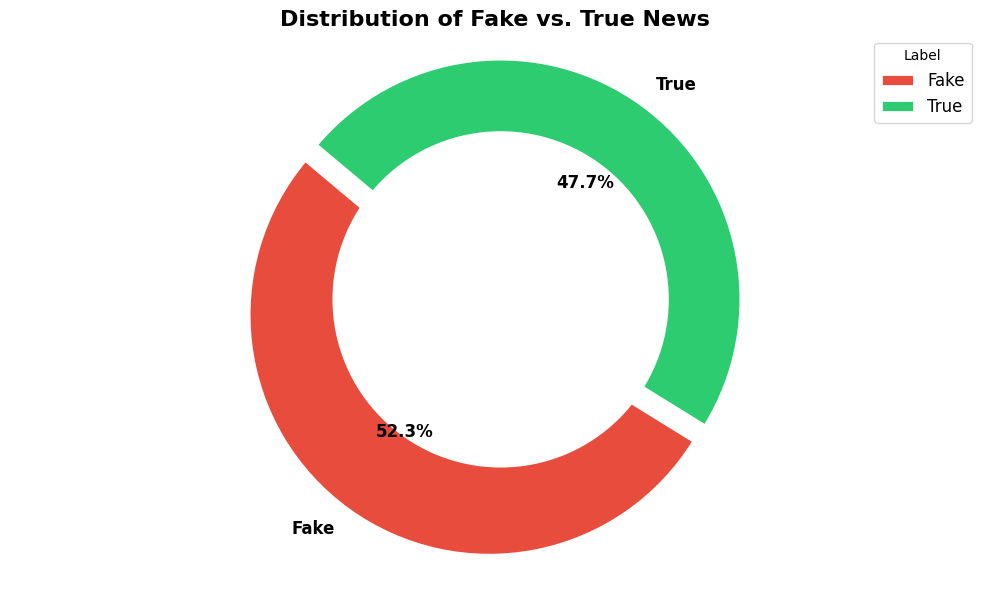

In [4]:
# ====================================
# Donut Chart: Label Distribution with High Contrast Colors
# ====================================

fig, ax = plt.subplots(figsize=(10, 6))

# Prepare data
labels = ['Fake', 'True']
sizes = df['label'].value_counts().sort_index().values  # ensure label order 0 -> 1
colors = ['#E74C3C', '#2ECC71']  # Red for Fake, Green for True

# Plot donut chart (pie chart with white circle in center)
wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    startangle=140,
    explode=(0.08, 0),
    wedgeprops={'edgecolor': 'white', 'linewidth': 2}
)

# Draw center circle to make it a donut
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# Title and legend
ax.set_title('Distribution of Fake vs. True News', fontsize=16, weight='bold')
ax.axis('equal')
ax.legend(wedges, labels, title="Label", loc='upper right', fontsize=12)

# Customize text
for txt in texts + autotexts:
    txt.set_fontsize(12)
    txt.set_fontweight('bold')

plt.tight_layout()
plt.show()



### News Length Distribution 📊

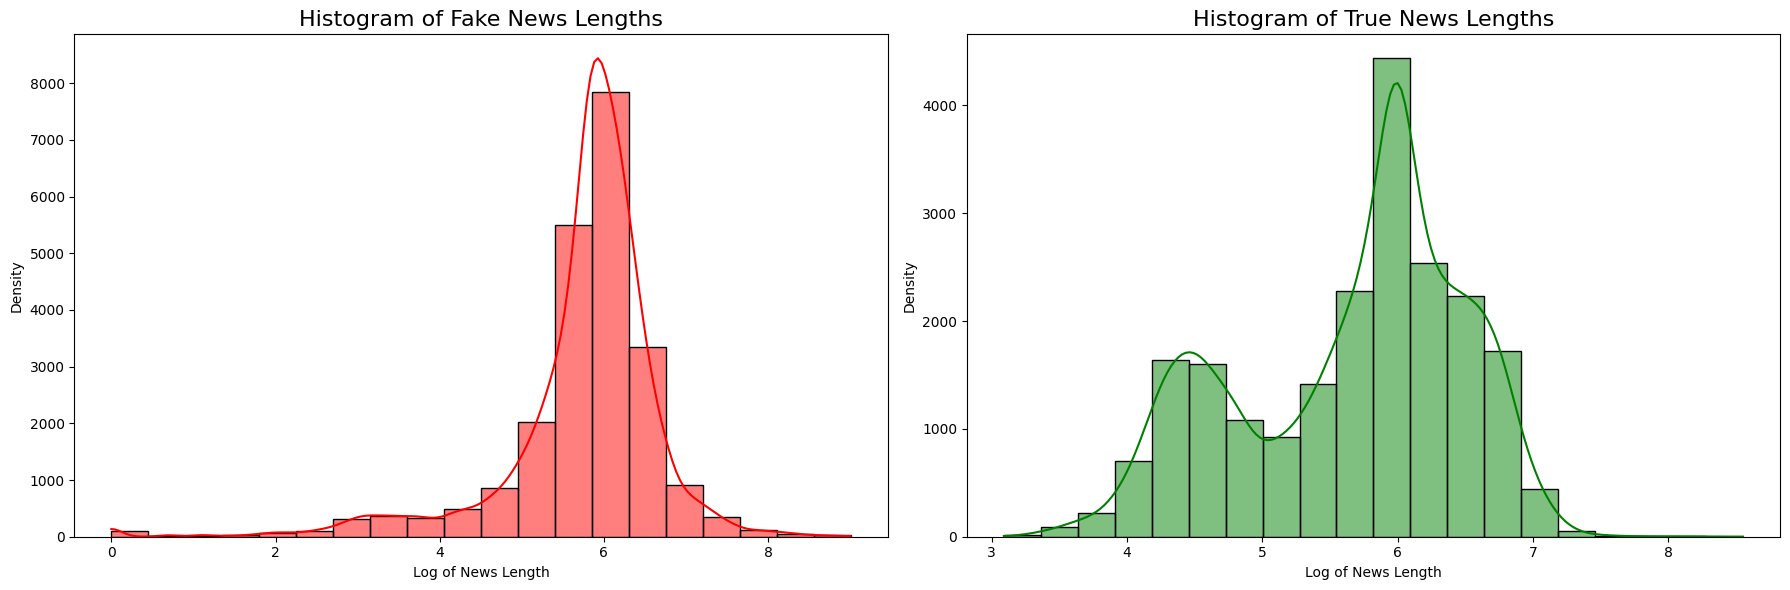

In [6]:
# ==========================================
# Histogram of News Lengths by Label (log)
# ==========================================

# Define label info
label_map = {0: 'Fake', 1: 'True'}
colors = {0: 'red', 1: 'green'}  # Use high-contrast colors

# Calculate log lengths
log_lengths = {
    label: np.log([len(news.split()) for news in df[df['label'] == label]['text']])
    for label in label_map
}

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot histograms
for idx, label in enumerate(label_map):
    sns.histplot(
        log_lengths[label],
        bins=20,
        color=colors[label],
        kde=True,
        ax=axes[idx]
    )
    axes[idx].set_title(f'Histogram of {label_map[label]} News Lengths', fontsize=16)
    axes[idx].set_xlabel('Log of News Length')
    axes[idx].set_ylabel('Density')

plt.tight_layout()
plt.show()

In [6]:
%%time

# Clean and preprocess the dataset using the unified function
df['text'] = df['text'].apply(clean_and_preprocess)

# Display the preprocessed dataset
df.head()

CPU times: total: 55 s
Wall time: 55.4 s


,text,label
0,donald trump white hous chao tri cover russia ...,0
1,donald trump presumpt gop nomine time rememb c...,0
2,mike penc huge homophob support ex gay convers...,0
3,san francisco reuter california attorney gener...,1
4,twist reason come pelosi day especi promin dem...,0


In [7]:
# ====================================
# Split Dataset into Train and Test
# ====================================

X = df.drop(columns=['label'])
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

# Print shapes of splits
print(f'\nTrain Features: {X_train.shape}, Train Labels: {y_train.shape}')
print(f'Test Features : {X_test.shape}, Test Labels : {y_test.shape}')



Train Features: (35918, 1), Train Labels: (35918,)
Test Features : (8980, 1), Test Labels : (8980,)


In [8]:
# Initialize and fit tokenizer on training data
tokenizer = Tokenizer()
if not X_train.empty and 'text' in X_train.columns:
    tokenizer.fit_on_texts(X_train['text'])
else:
    raise ValueError("X_train is empty or does not contain 'text' column")

# Convert texts to sequences using list comprehension
train_seq = tokenizer.texts_to_sequences(X_train['text'])
test_seq = tokenizer.texts_to_sequences(X_test['text'])

# Determine vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# Pad sequences with dynamic maxlen and consistent padding
train_seq = pad_sequences(train_seq, padding='post', truncating='post', dtype='int32', value=0)
test_seq = pad_sequences(test_seq, padding='post', truncating='post', dtype='int32', value=0)
max_length = train_seq.shape[1]

In [9]:
import numpy as np

# Constants
GLOVE_FILE = 'glove.6B.300d.txt'
EPOCHS = 1
LEARNING_RATE = 1e-3
EMBEDDING_DIM = 300

# Load GloVe embeddings
embeddings_index = {}
try:
    with open(GLOVE_FILE, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            if len(values) != EMBEDDING_DIM + 1:  # Check for valid line format
                continue
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
except FileNotFoundError:
    raise FileNotFoundError(f"Could not find {GLOVE_FILE}. Please check the file path.")
except Exception as e:
    raise ValueError(f"Error processing {GLOVE_FILE}: {str(e)}")

# Initialize and populate embedding matrix
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [10]:
# Define model hyperparameters
LSTM_UNITS_1 = 128
LSTM_UNITS_2 = 64
DENSE_UNITS = 256
DROPOUT_RATE_1 = 0.2
DROPOUT_RATE_2 = 0.5
LEARNING_RATE = 1e-3

# Define the model
model = Sequential([
    # Input layer specifying the shape of the padded sequences
    Input(shape=(max_length,)),
    
    # Embedding layer with pre-trained weights (non-trainable)
    Embedding(input_dim=vocab_size, 
              output_dim=EMBEDDING_DIM, 
              trainable=False),
    
    # Bidirectional LSTM layers for sequence processing
    Bidirectional(LSTM(LSTM_UNITS_1, return_sequences=True)),
    Bidirectional(LSTM(LSTM_UNITS_2)),
    Dropout(DROPOUT_RATE_1),
    
    # Dense layers for classification
    Dense(DENSE_UNITS, activation='relu'),
    Dropout(DROPOUT_RATE_2),
    
    # Output layer for binary classification
    Dense(1, activation='sigmoid')
])

# Set the pre-trained embedding weights
expected_shape = (vocab_size, EMBEDDING_DIM)
if embedding_matrix.shape == expected_shape:
    model.layers[0].set_weights([embedding_matrix])
else:
    raise ValueError(f"Embedding matrix shape {embedding_matrix.shape} does not match expected shape {expected_shape}")

# Compile the model
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss=BinaryCrossentropy(),
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4975, 300)         23158500  
                                                                 
 bidirectional (Bidirectiona  (None, 4975, 256)        439296    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 256)               33024     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0

In [ ]:
%%time
# train the model

history = model.fit(train_seq, y_train, epochs = EPOCHS, validation_split = 0.2)

898/898 [==============================] - 756s 838ms/step - loss: 0.0214 - accuracy: 0.9952 - val_loss: 0.0120 - val_accuracy: 0.9981
CPU times: total: 9min 44s
Wall time: 12min 35s


In [12]:
# get predictions

y_pred_train = np.round(model.predict(train_seq, verbose = 0))
y_pred_test = np.round(model.predict(test_seq, verbose = 0))

In [13]:
# display the accuracy

print(f'Train Accuracy : {accuracy_score(y_train, y_pred_train) * 100:.2f} %')
print(f'Test Accuracy  : {accuracy_score(y_test, y_pred_test) * 100:.2f} %')

Train Accuracy : 99.86 %
Test Accuracy  : 99.88 %


In [14]:
# display classification report

print(f'Classification Report (Train) : \n\n{classification_report(y_train, y_pred_train)}')
print('-----------------------------------------------------')
print(f'\nClassification Report (Test)  : \n\n{classification_report(y_test, y_pred_test)}')

Classification Report (Train) : 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18755
           1       1.00      1.00      1.00     17163

    accuracy                           1.00     35918
   macro avg       1.00      1.00      1.00     35918
weighted avg       1.00      1.00      1.00     35918

-----------------------------------------------------

Classification Report (Test)  : 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4726
           1       1.00      1.00      1.00      4254

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



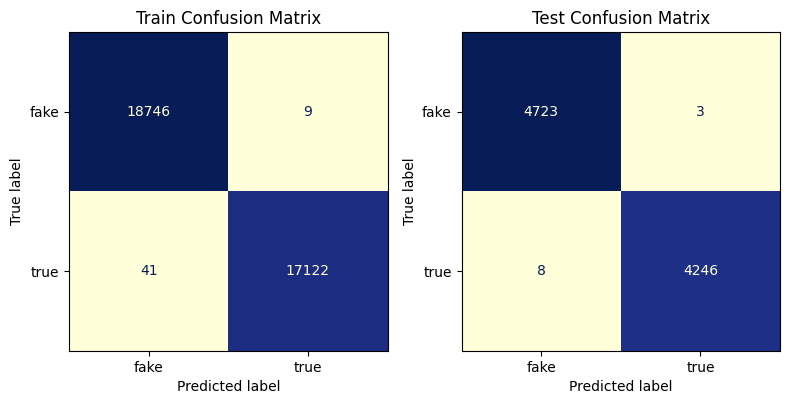

In [15]:
train_matrix = confusion_matrix(y_train, y_pred_train)
test_matrix = confusion_matrix(y_test, y_pred_test)

class_labels = ['fake', 'true']

disp_train = ConfusionMatrixDisplay(confusion_matrix = train_matrix, display_labels = class_labels)
disp_test = ConfusionMatrixDisplay(confusion_matrix = test_matrix, display_labels = class_labels)

fig, axs = plt.subplots(1, 2, figsize = (8, 12))

# train

disp_train.plot(ax = axs[0], cmap = 'YlGnBu', colorbar = False)
axs[0].set_title('Train Confusion Matrix')

# test

disp_test.plot(ax = axs[1], cmap = 'YlGnBu', colorbar = False)
axs[1].set_title('Test Confusion Matrix')

plt.tight_layout()
plt.show()